In [27]:
"""
View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
torchvision
matplotlib
"""
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)
angle=270
# plot one example
# print(train_data.train_data.size())                 # (60000, 28, 28)
# print(train_data.train_labels.size())               # (60000)
# print(train_data.train_data[0].size())
# print(train_data.train_data[0])


# img1 = transforms.RandomRotation()(train_data.train_data)
# img2 = torchvision.transforms.RandomHorizontalFlip()(train_data.train_data[0])
# img3 = torchvision.transforms.RandomHorizontalFlip()(train_data.train_data[0])
# plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
# plt.subplot(2,2,1),plt.imshow(train_data.train_data[0].numpy()),plt.title("原图")
# plt.subplot(2,2,2),plt.imshow(img1.numpy()),plt.title("转换后的图1")
# print(img1.size)

# plt.subplot(2,2,2),plt.imshow(img1[0].numpy()),plt.title("1")
# plt.subplot(2,2,3),plt.imshow(img2.numpy()),plt.title("2")
# plt.subplot(2,2,4),plt.imshow(img3.numpy()),plt.title("3")
# plt.title('%i' % train_data.train_labels[0])
# plt.show()

# print("随机裁剪后的大小:",data1.size)
# data2 = transforms.RandomResizedCrop(224)(img)
# data3 = transforms.RandomResizedCrop(224)(img)

# plt.subplot(2,2,1),plt.imshow(img),plt.title("原图")
# plt.subplot(2,2,2),plt.imshow(data1),plt.title("转换后的图1")
# plt.subplot(2,2,3),plt.imshow(data2),plt.title("转换后的图2")
# plt.subplot(2,2,4),plt.imshow(data3),plt.title("转换后的图3")
# plt.show()
# 数据加载器，用于在训练中简单地进行小批量返回，图像批量形状将为（50，1，28，28）
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# print(train_loader[0])
# train_data.train_data=transforms.RandomRotation(100)(train_data.train_data)
# 采集2000个样本以加快测试速度
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test=transforms.RandomRotation(angle)(test_data.test_data)

test_x = torch.unsqueeze(test, dim=1).type(torch.FloatTensor)[:2000].cuda()/255.   # Tensor on GPU  # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000].cuda()




In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
# !!!!!!!! Change in here !!!!!!!!! #
cnn.cuda()      # Moves all model parameters and buffers to the GPU.
# print(cnn)  # net architecture

cnn.load_state_dict(torch.load('net_params.pkl'))
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = False
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        x=transforms.RandomRotation(angle)(x)
        b_x = x.cuda()    # Tensor on GPU
        b_y = y.cuda()    # Tensor on GPU

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            # !!!!!!!! Change in here !!!!!!!!! #
            pred_y = torch.max(test_output, 1)[1].cuda().data  # move the computation in GPU
            # pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            # print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)

            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.cpu().numpy()[:plot_only, :])
                labels = test_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
# pred_y = torch.max(test_output, 1)[1].data.numpy()
# !!!!!!!! Change in here !!!!!!!!! #
pred_y = torch.max(test_output, 1)[1].cuda().data # move the computation in GPU
print(pred_y, 'prediction number')
print(test_y[:10].cpu().numpy(), 'real number')

torch.save(cnn.state_dict(), 'net_params.pkl')   # 只保存网络中的参数 (速度快, 占内存少)

Epoch:  0 | train loss: 0.2845 | test accuracy: 0.86
Epoch:  0 | train loss: 0.2011 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3570 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2322 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2672 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2163 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1796 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3700 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3066 | test accuracy: 0.91
Epoch:  0 | train loss: 0.4031 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1543 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2217 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1378 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2556 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3225 | test accuracy: 0.91
Epoch:  0 | train loss: 0.0840 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1645 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1847 | test accuracy: 0.92
Epoch:  0 | train loss: 0.4769 | test accuracy

In [30]:
"""
View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
torchvision
matplotlib
"""
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# torch.manual_seed(1)    # reproducible
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False
# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)
angle=270
# 数据加载器，用于在训练中简单地进行小批量返回，图像批量形状将为（50，1，28，28）
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 采集2000个样本以加快测试速度
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test=transforms.RandomRotation(angle)(test_data.test_data)

test_x = torch.unsqueeze(test, dim=1).type(torch.FloatTensor)[:2000].cuda()/255.   # Tensor on GPU  # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000].cuda()
output = cnn(test_x[0])[0]  

pred_y = torch.max(output, 1)[1].cuda().data # move the computation in GPU
print(pred_y)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x49 and 1568x10)

In [18]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
import copy
import time
from digit_recog import Net
from digit_recog_mydataset import MyDataset
 
 
# 读取已保存的模型
def getmodel(pth, net):
    state_filepath = pth
    if os.path.exists(state_filepath):
        # 加载参数
nn_state = torch.load(state_filepath)
        # 加载模型
net.load_state_dict(nn_state)
        # 拷贝一份
return copy.deepcopy(nn_state)
    else:
        return net.state_dict()
 
 
# 构建数据集
def getdataset(batch_size):
    # 定义数据预处理方式
transform = transforms.ToTensor()
 
    # 定义训练数据集
trainset = tv.datasets.MNIST(
        root='./data/',
train=True,
download=True,
transform=transform)
 
    # 去掉注释，加入自己的数据集
# trainset += MyDataset(os.path.abspath("./data/myimages/"), 'train.txt', transform=transform)
 
    # 定义训练批处理数据
trainloader = torch.utils.data.DataLoader(
        trainset,
batch_size=batch_size,
shuffle=True,
)
 
    # 定义测试数据集
testset = tv.datasets.MNIST(
        root='./data/',
train=False,
download=True,
transform=transform)
 
    # 去掉注释，加入自己的数据集
# testset += MyDataset(os.path.abspath("./data/myimages/"), 'test.txt', transform=transform)
 
    # 定义测试批处理数据
testloader = torch.utils.data.DataLoader(
        testset,
batch_size=batch_size,
shuffle=False,
)
 
    return trainloader, testloader
 
 
# 训练
def training(device, net, model, dataset_loader, epochs, criterion, optimizer, save_model_path):
    trainloader, testloader = dataset_loader
    # 最佳模型
best_model_wts = model
    # 最好分数
best_acc = 0.0
# 计时
since = time.time()
    for epoch in range(epochs):
        sum_loss = 0.0
# 训练数据集
for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # 梯度清零，避免带入下一轮累加
optimizer.zero_grad()
            # 神经网络运算
outputs = net(inputs)
            # 损失值
loss = criterion(outputs, labels)
            # 损失值反向传播
loss.backward()
            # 执行优化
optimizer.step()
            # 损失值汇总
sum_loss += loss.item()
            # 每训练完100条数据就显示一下损失值
if i % 100 == 99:
                print('[%d, %d] loss: %.03f'
% (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
# 每训练完一轮测试一下准确率
with torch.no_grad():
            correct = 0
total = 0
for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                # 取得分最高的
_, predicted = torch.max(outputs.data, 1)
                # print(labels)
                # print(torch.nn.Softmax(dim=1)(outputs.data).detach().numpy()[0])
                # print(torch.nn.functional.normalize(outputs.data).detach().numpy()[0])
total += labels.size(0)
                correct += (predicted == labels).sum()
 
            print('测试结果:{}/{}'.format(correct, total))
            epoch_acc = correct.double() / total
            print('当前分数:{} 最高分数:{}'.format(epoch_acc, best_acc))
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
            print('第%d轮的识别准确率为：%d%%' % (epoch + 1, (100 * correct / total)))
 
    time_elapsed = time.time() - since
    print('训练完成于 {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('最高分数: {:4f}'.format(best_acc))
    # 保存训练模型
if save_model_path is not None:
        save_state_path = os.path.join('model/', 'net.pth')
        torch.save(best_model_wts, save_state_path)
 
 
# 基于cpu还是gpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NET = Net().to(DEVICE)
# 超参数设置
EPOCHS = 8# 训练多少轮
BATCH_SIZE = 64  # 数据集批处理数量 64
LR = 0.001  # 学习率
 
# 交叉熵损失函数，通常用于多分类问题上
CRITERION = nn.CrossEntropyLoss()
# 优化器
# OPTIMIZER = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
OPTIMIZER = optim.Adam(NET.parameters(), lr=LR)
MODEL = getmodel(os.path.join('model/', 'net.pth'), NET)
training(DEVICE, NET, MODEL, getdataset(BATCH_SIZE), 1, CRITERION, OPTIMIZER, os.path.join('model/', 'net.pth'))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 117)

torch.Size([60000, 28, 28])
torch.Size([60000])


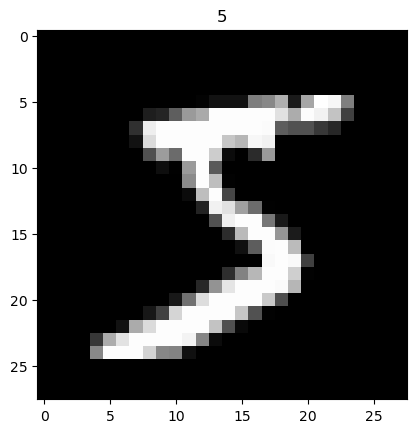

Epoch:  0 | train loss: 2.3961 | test accuracy: 0.11
Epoch:  0 | train loss: 1.6933 | test accuracy: 0.20
Epoch:  0 | train loss: 1.4578 | test accuracy: 0.17
Epoch:  0 | train loss: 1.3925 | test accuracy: 0.46
Epoch:  0 | train loss: 1.0747 | test accuracy: 0.45
Epoch:  0 | train loss: 0.8234 | test accuracy: 0.44
Epoch:  0 | train loss: 0.7360 | test accuracy: 0.59
Epoch:  0 | train loss: 1.1119 | test accuracy: 0.50
Epoch:  0 | train loss: 0.8792 | test accuracy: 0.46
Epoch:  0 | train loss: 0.8602 | test accuracy: 0.63
Epoch:  0 | train loss: 0.5425 | test accuracy: 0.71
Epoch:  0 | train loss: 0.8942 | test accuracy: 0.50
Epoch:  0 | train loss: 0.6891 | test accuracy: 0.65
Epoch:  0 | train loss: 0.6167 | test accuracy: 0.63
Epoch:  0 | train loss: 0.5870 | test accuracy: 0.63
Epoch:  0 | train loss: 0.6215 | test accuracy: 0.70
Epoch:  0 | train loss: 0.6699 | test accuracy: 0.66
Epoch:  0 | train loss: 0.5001 | test accuracy: 0.61
Epoch:  0 | train loss: 0.5575 | test accuracy

KeyboardInterrupt: 

In [4]:
"""
View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
torchvision
matplotlib
"""
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False
train_transform = transforms.Compose([
                                transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                transforms.RandomRotation((-180,180)),        #随机旋转
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])

test_transform = transforms.Compose([transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                    transforms.ToTensor(),
                                    transforms.RandomRotation((-180,180)),        #随机旋转
                                    transforms.Normalize((0.1307,),(0.3081,))])


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=train_transform,    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False,transform=test_transform)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000].cuda()/255.   # Tensor on GPU  # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000].cuda()


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
# !!!!!!!! Change in here !!!!!!!!! #
cnn.cuda()      # Moves all model parameters and buffers to the GPU.
# print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = False
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = x.cuda()    # Tensor on GPU
        b_y = y.cuda()    # Tensor on GPU

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            # !!!!!!!! Change in here !!!!!!!!! #
            pred_y = torch.max(test_output, 1)[1].cuda().data  # move the computation in GPU
            # pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            # print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)

            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.cpu().numpy()[:plot_only, :])
                labels = test_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
# pred_y = torch.max(test_output, 1)[1].data.numpy()
# !!!!!!!! Change in here !!!!!!!!! #
pred_y = torch.max(test_output, 1)[1].cuda().data # move the computation in GPU
print(pred_y, 'prediction number')
print(test_y[:10].cpu().numpy(), 'real number')

In [ ]:
train_epoch = []
model_accuracy = []
temp_acc = 0.0
train_loss_val = []
for epoch in range(30):
    train(epoch)
    acc = test()

    print(epoch + 1,acc)
    train_epoch.append(epoch)
    model_accuracy.append(acc)
    scheduler.step(acc)
    torch.save(model.state_dict(), 'params\\'+str(epoch + 31)+'-'+str(acc)+'-'+'net_params.pt')   # 只保存网络中的参数 (速度快, 占内存少)

plt.figure(1)
plt.plot(train_epoch, model_accuracy)  # 传入列表，plt类用来画图
plt.grid(linestyle=':')
plt.ylabel('accuracy')  # 定义y坐标轴的名字
plt.xlabel('epoch')  # 定义x坐标
plt.show()  # 显示

Accuracy on test set: 97.570000 % [9757/10000]
1 0.9757
Accuracy on test set: 97.460000 % [9746/10000]
2 0.9746
Accuracy on test set: 97.590000 % [9759/10000]
3 0.9759
Accuracy on test set: 97.690000 % [9769/10000]
4 0.9769
Accuracy on test set: 97.430000 % [9743/10000]
5 0.9743
Accuracy on test set: 97.590000 % [9759/10000]
6 0.9759
Accuracy on test set: 97.510000 % [9751/10000]
7 0.9751
Epoch 00007: reducing learning rate of group 0 to 7.5000e-03.
Accuracy on test set: 97.520000 % [9752/10000]
8 0.9752
Accuracy on test set: 97.620000 % [9762/10000]
9 0.9762
Accuracy on test set: 97.490000 % [9749/10000]
10 0.9749
Epoch 00010: reducing learning rate of group 0 to 3.7500e-03.
Accuracy on test set: 97.620000 % [9762/10000]
11 0.9762
Accuracy on test set: 97.620000 % [9762/10000]
12 0.9762
Accuracy on test set: 97.680000 % [9768/10000]
13 0.9768
Epoch 00013: reducing learning rate of group 0 to 1.8750e-03.
Accuracy on test set: 97.680000 % [9768/10000]
14 0.9768
Accuracy on test set: 97.

torch.Size([60000, 28, 28])
torch.Size([60000])


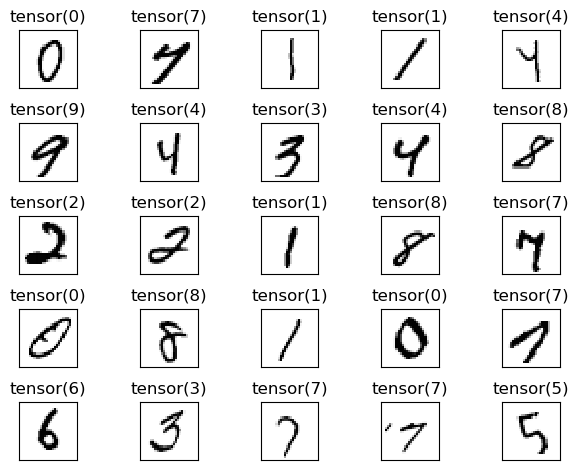

In [2]:
"""
View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
torchvision
matplotlib
"""
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False
train_transform = transforms.Compose([
                                transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                transforms.RandomRotation(90),        #随机旋转
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])

test_transform = transforms.Compose([transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                    transforms.ToTensor(),
                                    transforms.RandomRotation((-90,180)),        #随机旋转
                                    transforms.Normalize((0.1307,),(0.3081,))])


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=train_transform,    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
    
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())   
i=10            # (60000)
# while(i):
#     i-=1
#     plt.imshow(train_data.train_data[i].numpy(), cmap='gray')
#     plt.title('%i' % train_data.train_labels[i])
#     plt.show()
k=1000
fig, ax = plt.subplots(nrows=5, ncols=5, sharex='all', sharey='all')
ax = ax.flatten()
transforms.RandomRotation(90)(train_data.train_data)
for i in range(25):
    # img = transforms.RandomRotation(270)(train_data.train_data[i+k])
    img=train_data.train_data[i+k].numpy()
    ax[i].set_title(train_data.train_labels[i+k])
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()